In [1]:
from itertools import chain
import os
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np

from run_cifar10 import gen_sweep


In [43]:
arch = 'resnet32'
data = 'CIFAR10'
modifier = ''
modifier = '_no_batchnorm'

skips = ['kradapoo']

hyperparams_to_sweep_precon = SimpleNamespace(
    optimizer=['kradmm', 'krad', 'shampoo', 'kradapoo'],  
    epochs=['250'],
    eps_str=['1e-4'],
    lr_str=['1', '2.5e-1', '1e-1', '2.5e-2', '1e-2'],
)

hyperparams_to_sweep_gd = SimpleNamespace(
    optimizer=['sgd'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


hyperparams_to_sweep_ada = SimpleNamespace(
    optimizer=['ada'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)

loss_s, prec_s = fetch_loss_prec(arch, data, modifier, [
    hyperparams_to_sweep_precon, hyperparams_to_sweep_gd, hyperparams_to_sweep_ada
])

['CIFAR10_resnet32_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_sgd_eps1e-1_lr5e-3_batch128.npy']
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_ada_eps1e-1_lr5e-3_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-1_batch128.npy
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-2_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_shampoo_eps1e-4_lr1e-2_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1e-1

In [45]:
def fetch_loss_prec(arch, data, modifier, hyperparms_list, fn_modifier=''):
    #save_dir = '{}_{}_ckpts'.format(arch, data)
    save_dir = '{}_{}{}_ckpts'.format(data, arch, modifier)
    batch_size = 128
    activation='relu'


    loss_s = {}
    prec_s = {}

    #opts = ['ada','sgd','krad','kradmm','shampoo','kradapoo']
    opts = ['sgd', 'ada', 'shampoo', 'krad','kradmm']
    for opt in opts:
        args_sweeps_list = [gen_sweep(x.__dict__) for x in hyperparms_list]
        args_sweeps = chain(*args_sweeps_list)

        loss_prec = 1  #loss=0; prec=1
        best = -np.inf if loss_prec else np.inf
        best_name = ''
        for args in args_sweeps:
            if args.optimizer != opt: continue
            opt_modifier_str = (
                '_eps{}_lr{}_batch{}'.format(
                    args.eps_str, args.lr_str, batch_size
                )
            ) + (
                '_soft' if activation=='softplus' else ''
            ) + fn_modifier
            loss_fn = os.path.join(save_dir, 'loss_{}{}.npy'.format(opt, opt_modifier_str))
            prec_fn = os.path.join(save_dir, 'prec_{}{}.npy'.format(opt, opt_modifier_str))
            
            try:
                loss_, prec_ = [np.load(x) for x in [loss_fn, prec_fn]]

                tr_or_va = 1  # train=0; validation=1
                if loss_prec:
                    if prec_[:, tr_or_va][-1] > best:
                        best = prec_[:, tr_or_va][-1]
                        best_name = opt_modifier_str
                else:
                    if loss_[:, tr_or_va][-1] < best:
                        best = loss_[:, tr_or_va][-1]
                        best_name = opt_modifier_str
                    
            except:
                print('file not found: {}'.format(loss_fn))
        loss_fn = os.path.join(save_dir, 'loss_{}{}.npy'.format(opt, best_name))
        prec_fn = os.path.join(save_dir, 'prec_{}{}.npy'.format(opt, best_name))
        print([loss_fn, prec_fn])
        try:
            loss_, prec_ = [np.load(x) for x in [loss_fn, prec_fn]]
            loss_s[opt] = loss_
            prec_s[opt] = prec_
        except:
            print('-> opt failed: {}'.format(opt))
    return loss_s, prec_s

def plot_all(loss_s, prec_s, skips=[]):

    opts_to_plot = [key for key in loss_s.keys() if key not in skips]

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(loss_s[opt_name_][:, 0])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train loss')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(loss_s[opt_name_][:, 1])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test loss')

    opts_to_plot = [key for key in prec_s.keys() if key not in skips]
    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.plot(prec_s[opt_name_][:, 0])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train precisions [%]')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.plot(prec_s[opt_name_][:, 1])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test precisions [%]')
    
    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(100-prec_s[opt_name_][:, 0])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train errors [%]')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(100-prec_s[opt_name_][:, 1])
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test errors [%]')

    plt.show()
    

flatten = lambda z: [x for y in z for x in y]


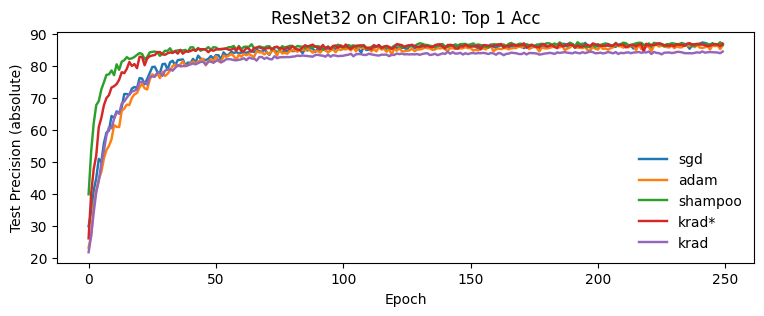

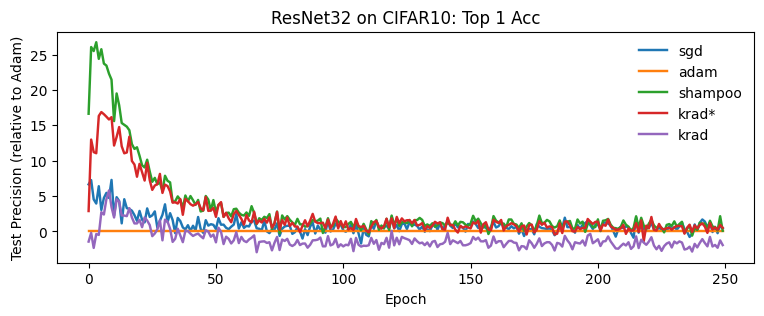

In [46]:
import seaborn as sns
#sns.set_style('white', rc={'figure.figsize':(5,3)})
import matplotlib as mpl
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 9, 3



ordered_opt_names = ['sgd', 'ada', 'shampoo', 'krad', 'kradmm']


def plot(prec_s, rel=True):
    opt_names = [key for key in prec_s.keys() if key not in skips]
    #sh32ix = [ix for ix, name_ in enumerate(opt_names) if all([tgt in name_ for tgt in ['shampoo', 'double0']])][0]
    #opt_names.append(opt_names.pop(sh32ix))
    
    fig, ax = plt.subplots()
    
    lines = []
    for opt_name_ in opt_names:
        
        if rel:
            yy = prec_s[opt_name_][:, 1] - prec_s['ada'][:, 1]
        else:
            yy = prec_s[opt_name_][:, 1]
        g = sns.lineplot(x=range(len(prec_s[opt_name_])), y=yy, linewidth=1.75)


    processed_opt_names = [name_.replace('kradmm', 'kramm') for name_ in opt_names]
    processed_opt_names = [name_.replace('krad', 'krad*') for name_ in processed_opt_names]
    processed_opt_names = [name_.replace('kramm', 'krad') for name_ in processed_opt_names]
    processed_opt_names = [name_.replace('ada', 'adam') for name_ in processed_opt_names]
    #processed_opt_names = [name_.replace('shampoo_', 'shampoo64_') if 'double1' in name_ else name_.replace('shampoo_', 'shampoo32_') for name_ in processed_opt_names]
    cropped_opt_names = [name_.split('_')[0] for name_ in processed_opt_names]
    
    g.legend(g.lines, cropped_opt_names, frameon=False)
    #g.set_yscale("log")
    plt.title('ResNet32 on CIFAR10: Top 1 Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Test Precision (relative to Adam)' if rel else 'Test Precision (absolute)')

plot(prec_s, rel=False)
plot(prec_s)

['CIFAR10_resnet32_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_sgd_eps1e-1_lr5e-3_batch128.npy']
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_ada_eps1e-1_lr5e-3_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-1_batch128.npy
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-2_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_shampoo_eps1e-4_lr1e-2_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1e-1

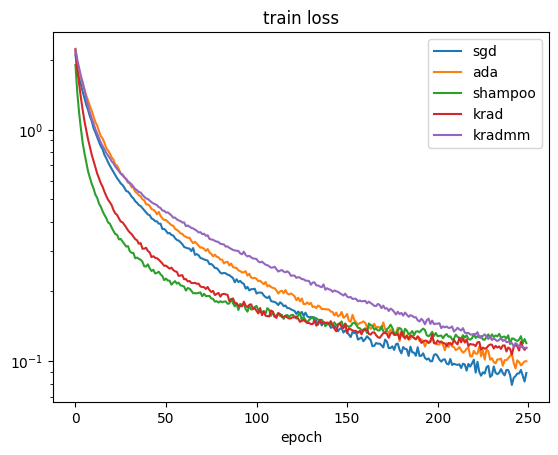

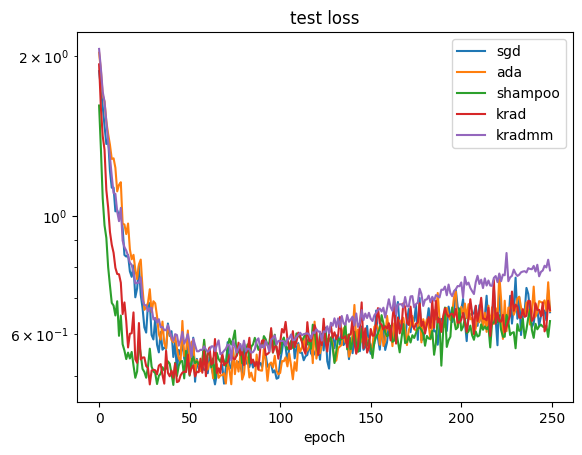

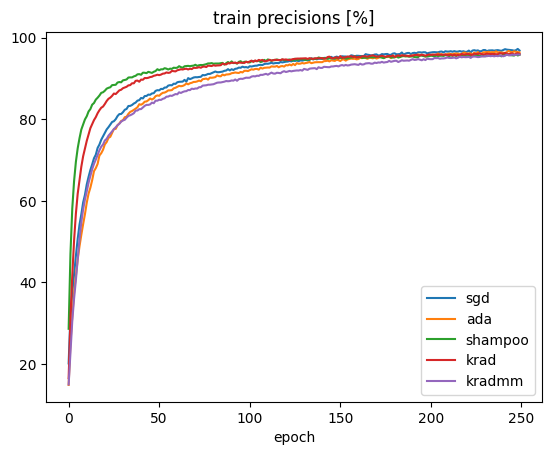

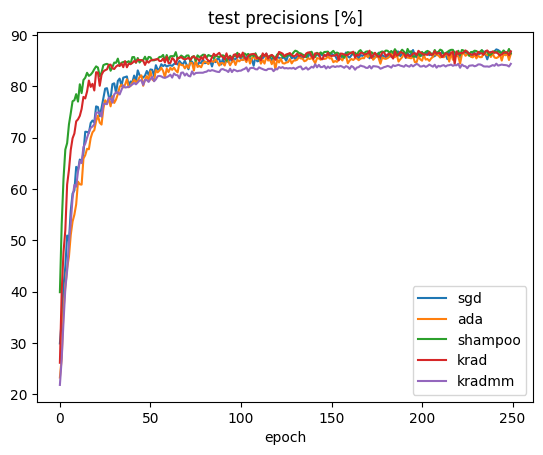

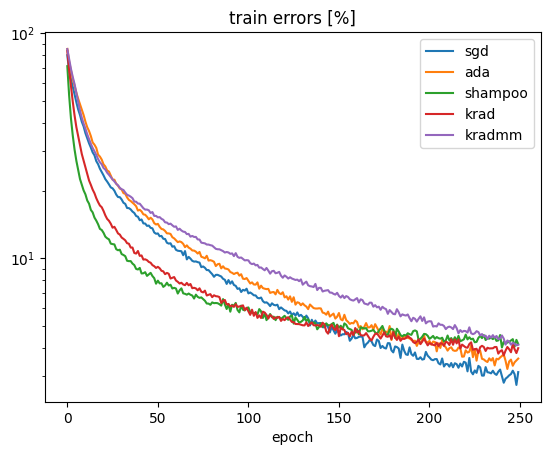

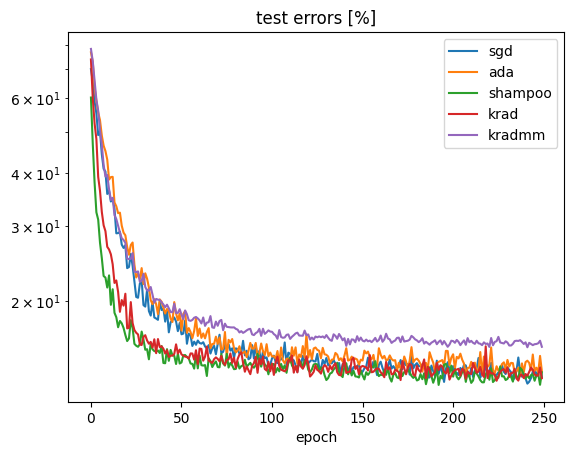

In [15]:
plot_all(loss_s, prec_s, skips)

In [41]:
###without batchnorm:
arch = 'resnet56'; data = 'CIFAR100'; exp_modifier = '_nohalf_no_batchnorm'; fn_modifier = ''


###with batchnorm:
##backwards, from old naming convention
#arch='CIFAR100'; data='resnet56'; exp_modifier = ''; fn_modifier = '_relu'

hyperparams_to_sweep_precon = SimpleNamespace(
    optimizer=['kradmm', 'krad', 'shampoo'],  
    epochs=['250'],
    eps_str=['1e-4'],
    lr_str=['1', '2.5e-1', '1e-1', '2.5e-2', '1e-2'],
)

hyperparams_to_sweep_gd = SimpleNamespace(
    optimizer=['sgd'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


hyperparams_to_sweep_ada = SimpleNamespace(
    optimizer=['ada'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


loss_s, prec_s = fetch_loss_prec(arch, data, exp_modifier, [
    hyperparams_to_sweep_precon, hyperparams_to_sweep_gd, hyperparams_to_sweep_ada
], fn_modifier=fn_modifier)

['CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr1e-2_batch128.npy', 'CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/prec_sgd_eps1e-1_lr1e-2_batch128.npy']
['CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy', 'CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/prec_ada_eps1e-1_lr5e-3_batch128.npy']
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr2.5e-2_batch128.npy
['CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_shampoo_eps1e-4_lr1e-2_batch128.npy', 'CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/prec_shampoo_eps1e-4_lr1e-2_batch128.npy']
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_krad_eps1e-4_lr

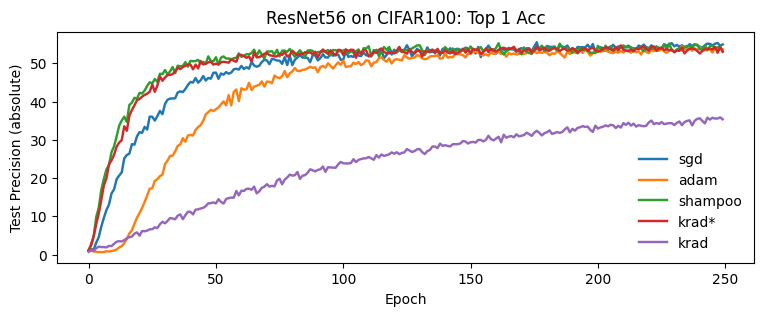

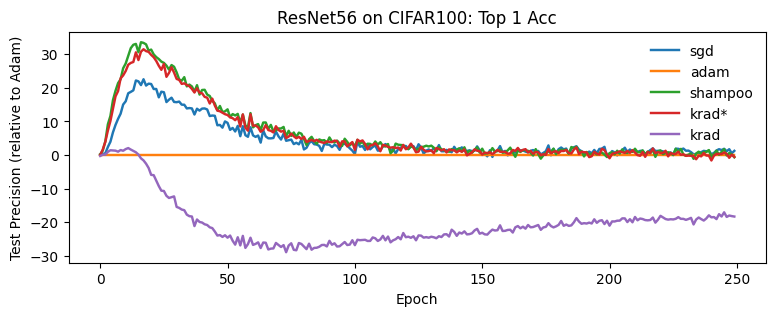

In [42]:
import seaborn as sns
#sns.set_style('white', rc={'figure.figsize':(5,3)})
import matplotlib as mpl
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 9, 3



ordered_opt_names = ['sgd', 'ada', 'shampoo', 'krad', 'kradmm']


def plot(prec_s, rel=True):
    opt_names = [key for key in prec_s.keys() if key not in skips]
    #sh32ix = [ix for ix, name_ in enumerate(opt_names) if all([tgt in name_ for tgt in ['shampoo', 'double0']])][0]
    #opt_names.append(opt_names.pop(sh32ix))
    
    fig, ax = plt.subplots()
    
    lines = []
    for opt_name_ in opt_names:
        
        if rel:
            yy = prec_s[opt_name_][:, 1] - prec_s['ada'][:, 1]
        else:
            yy = prec_s[opt_name_][:, 1]
        g = sns.lineplot(x=range(len(prec_s[opt_name_])), y=yy, linewidth=1.75)


    processed_opt_names = [name_.replace('kradmm', 'kramm') for name_ in opt_names]
    processed_opt_names = [name_.replace('krad', 'krad*') for name_ in processed_opt_names]
    processed_opt_names = [name_.replace('kramm', 'krad') for name_ in processed_opt_names]
    processed_opt_names = [name_.replace('ada', 'adam') for name_ in processed_opt_names]
    #processed_opt_names = [name_.replace('shampoo_', 'shampoo64_') if 'double1' in name_ else name_.replace('shampoo_', 'shampoo32_') for name_ in processed_opt_names]
    cropped_opt_names = [name_.split('_')[0] for name_ in processed_opt_names]
    
    g.legend(g.lines, cropped_opt_names, frameon=False)
    #g.set_yscale("log")
    plt.title('ResNet56 on CIFAR100: Top 1 Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Test Precision (relative to Adam)' if rel else 'Test Precision (absolute)')

plot(prec_s, rel=False)
plot(prec_s)

file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr2e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr2e-3_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-3_batch128.npy
['CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada.npy', 'CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/prec_ada.npy']
-> opt failed: ada
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr1e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr5e-2_

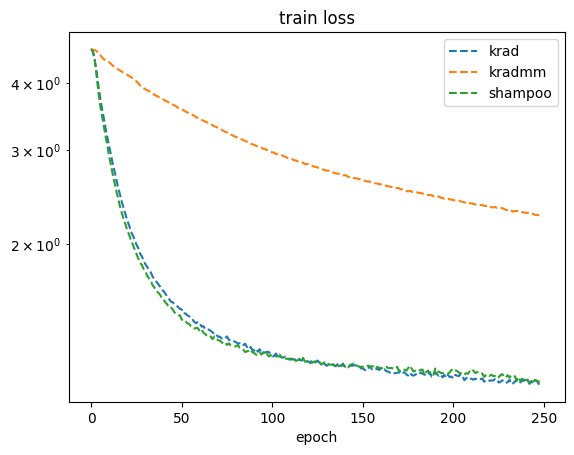

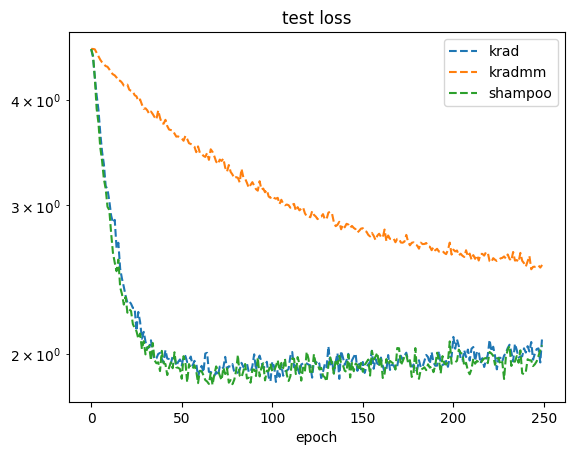

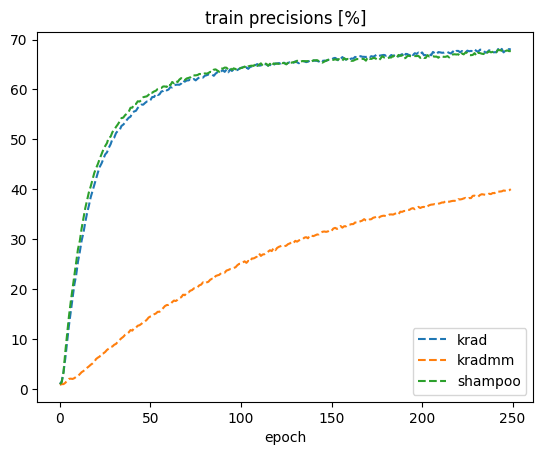

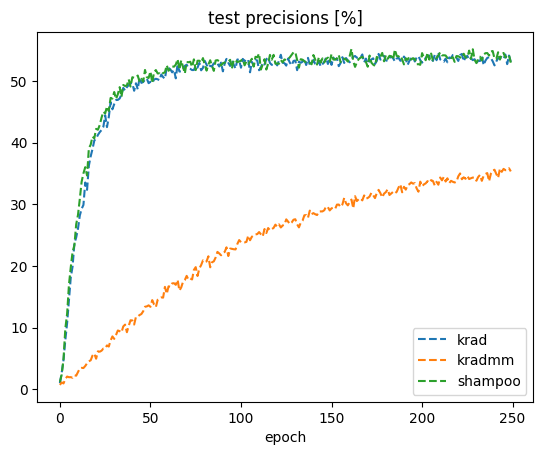

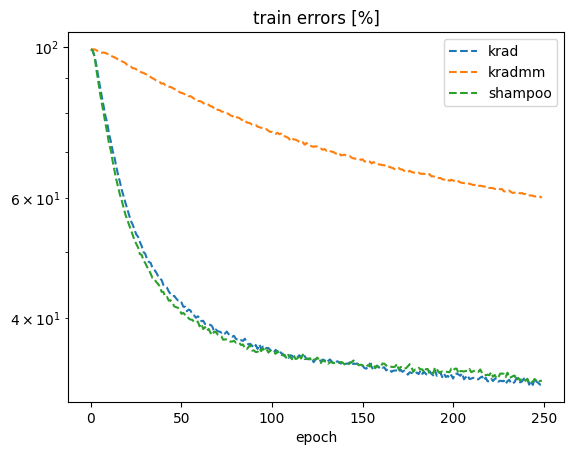

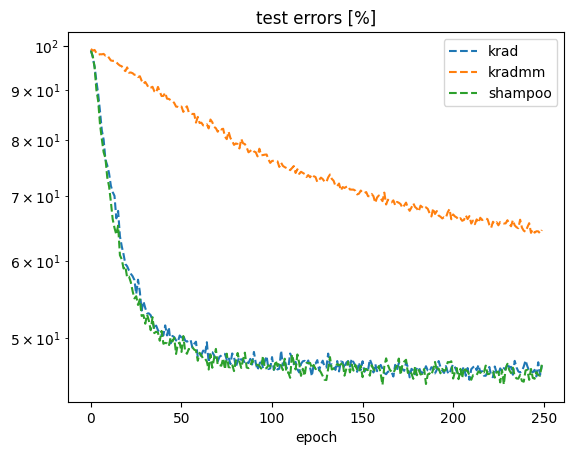

In [6]:
#opts_to_plot = ['ada', 'sgd', 'shampoo', 'krad', 'kradmm']
plot_all(loss_s, prec_s)